# Using the `ua-snap/downscale` repo for statistical downscaling of climate data

This notebook provides a step-by-step guide to using the [`downscale`](https://github.com/ua-snap/snap-geo) package conduct simple delta-downscaling of some CRU-TS 4.08 data.

This demonstration will be done with Chinook because that has beome our main processing system. 

## Setup

### Environment

You will want to spin up a compute node connect this notebook to it following the instructions in this [README](https://github.com/ua-snap/ardac-toolbox). The python code in the downscale repo needs to be accessible to this kernel, which can be achieved either by installing `downscale` as a package in the environment or by starting the jupyter server from within the base directory. Make sure the packages in the `requirements.txt` file are present in the environment. 

### Data

The CRU-TS data is available from the [CRU website](https://crudata.uea.ac.uk/cru/data/hrg/), part of the University of East Anglia. The files of interest have historically looked like `cru_ts<version>.<start year>.<end year>.<variable>.dat.nc.gz`. This repo has been used for the `tmp` and `pre` data. Download and unzip the data. 



Here's the imports we need:

In [15]:
from pathlib import Path
from functools import partial
import numpy as np
import rasterio as rio

from downscale import Baseline, Dataset, DeltaDownscale

# variable lookup (helps for consistency between processing rounds - last time we did this was a couple years ago)
config_lu = {
    "tas": {
        "cru_id": "tmp",
        "units": "C",
        "metric": "mean",
        "downscale_operation": "add",
        "rounding_precision": 1,
    },
    "pr": {
        "cru_id": "pre",
        "units": "mm",
        "metric": "total",
        "downscale_operation": "mult",
        "rounding_precision": 0,
    },
}

Start by setting some variables to specify inputs:  
* path to dataset to downscale:

In [16]:
var_id = input("Enter variable ID (tas or pr): ")
cru_var_id = config_lu[var_id]["name"]
cru_fp = f"/beegfs/CMIP6/kmredilla/cru_ts/cru_ts4.08.1901.2023.{cru_var_id}.dat.nc"

* path to directory containing baseline monthly climatology files to use (PRISM, 1961-1990):

In [17]:
clim_dir = Path(f"/beegfs/CMIP6/kmredilla/prism/{var_id}")

(Note, previous path for doing this processing with PRISM data is `/workspace/Shared/Tech_Projects/DeltaDownscaling/project_data/climatologies/prism`)

* number of cores to use for parallel processing:

In [18]:
# availability varies by Chinook node
ncpus = input("Enter number of CPUs to use: ")

* path to directory for output files:

In [22]:
output_dir = Path(f"/beegfs/CMIP6/kmredilla/downscaled/CRU_TS408/{var_id}")
output_dir.mkdir(exist_ok=True, parents=True)

### Processing

Create a `Baseline` object from the baseline files:

In [23]:
baseline = Baseline(sorted(list(clim_dir.glob("*.tif"))))

Create a historical `Dataset` object from the CRU-TS dataset:

(does some grid rearranging in background, hence the elapsed time. Also prints an obscure "level" value)

In [24]:


# not sure if these value should ever change atm.
clim_begin = "01-1961"
clim_end = "12-1990"
# the following variables seem to be determined by the input file(s)
#  but still need to be specified for now
variable = config_lu[var_id]["name"]
model = "ts408"
scenario = "historical"
project = "cru"
units = config_lu[var_id]["units"]
metric = config_lu[var_id]["metric"]

ds_args = (
    cru_fp,
    variable,
    model,
    scenario,
    project,
    units,
    metric,
)
ds_kwargs = {
    "method":"linear",
    "ncpus": ncpus,
}

# put on one line for timing purposes
%time historical = Dataset(*ds_args, **ds_kwargs)

4
CPU times: user 2.78 s, sys: 3.57 s, total: 6.35 s
Wall time: 18.5 s


Define some more options, and a function for rounding the outputs:

In [30]:
rounder = partial(np.around, decimals=config_lu[var_id]["rounding_precision"])
downscaling_operation = config_lu[var_id]["downscale_operation"]
out_varname = var_id
# probably don't need anomalies
anom = False
# interpolate across NA's using a spline
interp = True
find_bounds = False
fix_clim = False
aoi_mask = None


def round_it(arr):
    return rounder(arr)

Read in a mask from one of the PRSIM climatology files:

In [31]:
with rio.open(baseline.filelist[0]) as src:
    mask = src.read_masks(1)

Create a `DeltaDownscale` class using the above objects and options:

In [42]:
# FOR CRU WE PASS THE interp=True so we interpolate across space first when creating the Dataset()
# ^^ note from a script

dd_kwargs = {
    "baseline": baseline,
    "clim_begin": clim_begin,
    "clim_end": clim_end,
    "historical": historical,
    "future": None,
    "downscaling_operation": downscaling_operation,
    "mask": mask,
    "mask_value": 0,
    "ncpus": ncpus,
    "src_crs": {"init": "epsg:4326"},
    "src_nodata": None,
    "dst_nodata": None,
    "post_downscale_function": round_it,
    "varname": out_varname,
    "modelname": None,
    "anom": anom,
    "interp": interp,
    "find_bounds": find_bounds,
    "fix_clim": fix_clim,
    "aoi_mask": aoi_mask,
}

%time cru = DeltaDownscale(**dd_kwargs)

running interpolation across NAs -- base resolution
processing interpolation to convex hull in parallel using 36 cpus.
ds interpolated updated into self.ds
CPU times: user 11.2 s, sys: 11.5 s, total: 22.7 s
Wall time: 4min 11s


Run the downscaling:

In [43]:
%time cru.downscale(output_dir=output_dir)

| 0.50, 0.00, 0.00|
| 0.00,-0.50, 90.00|
| 0.00, 0.00, 1.00|
CPU times: user 2.02 s, sys: 1.24 s, total: 3.26 s
Wall time: 35.4 s


PosixPath('/beegfs/CMIP6/kmredilla/downscaled/CRU_TS408/pr')

If you are updating a dataset such as the [2km CRU TS precipitation](https://catalog.snap.uaf.edu/geonetwork/srv/eng/catalog.search#/metadata/9eeef879-42ee-4bbe-a54e-435716ad0c90):

remove / copy out the `anom` folders in the output directories if present, 

```
cd output_dir
mv pr/anom pr_anom
```

rename the folder according to the existing convention

```
mv pr pr_AK_CAN_2km_CRU_TS408_historical
```

zip it

```
zip -r pr_AK_CAN_2km_CRU_TS408_historical.zip pr_AK_CAN_2km_CRU_TS408_historical
```

and copy to the CKAN directory on poseidon

```
scp pr_AK_CAN_2km_CRU_TS408_historical.zip kmredilla@poseidon.snap.uaf.edu://workspace/CKAN/CKAN_Data/Base/AK_CAN_2km/historical/CRU_TS/Historical_Monthly_and_Derived_Precipitation_Products_2km_CRU_TS/
```




in case you want to check out any of the files:

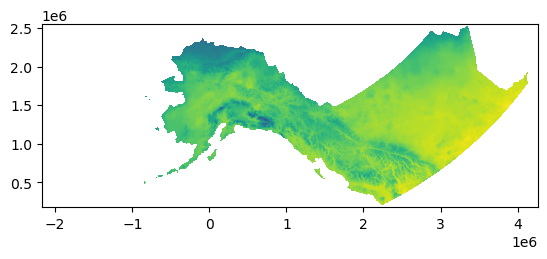

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 3218, 'height': 1186, 'count': 1, 'crs': CRS.from_wkt('PROJCS["NAD83 / Alaska Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",50],PARAMETER["longitude_of_center",-154],PARAMETER["standard_parallel_1",55],PARAMETER["standard_parallel_2",65],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3338"]]'), 'transform': Affine(2000.0, 0.0, -2173223.206087799,
       0.0, -2000.0, 2548412.932644147), 'blockxsize': 3218, 'blockysize': 1, 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


In [52]:
import rasterio as rio
from rasterio.plot import show

fp = output_dir.joinpath("tas_mean_C_cru_ts408_historical_05_1962.tif")
fp = "/beegfs/CMIP6/kmredilla/downscaled/CRU_TS408/tas_AK_CAN_2km_CRU_TS408_historical/tas_mean_C_cru_ts408_historical_05_1962.tif"
with rio.open(fp) as src1:
    show(src1)
    print(src1.profile)
    arr1 = src1.read(1)